In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

# Clustering de países con Gapminder

Este cuaderno explora el desarrollo de países usando el dataset Gapminder.
- Carga y limpieza básica de datos.
- Tratamiento de outliers y selección de variables.
- Preparación por años (1952 vs 2007) y escalado.
- Clustering jerárquico (Agglomerative) y dendrogramas.
- Visualizaciones comparativas de clusters.

In [ ]:
df = px.data.gapminder()
print(df.head())

       country continent  year  lifeExp       pop   gdpPercap iso_alpha  \
0  Afghanistan      Asia  1952   28.801   8425333  779.445314       AFG   
1  Afghanistan      Asia  1957   30.332   9240934  820.853030       AFG   
2  Afghanistan      Asia  1962   31.997  10267083  853.100710       AFG   
3  Afghanistan      Asia  1967   34.020  11537966  836.197138       AFG   
4  Afghanistan      Asia  1972   36.088  13079460  739.981106       AFG   

   iso_num  
0        4  
1        4  
2        4  
3        4  
4        4  


## Carga de datos

Usamos `plotly.express` para obtener el dataset público de Gapminder con indicadores por país y año.

In [20]:
df = df.drop(columns=['iso_alpha'])
df = df.drop(columns=['iso_num'])

## Selección de variables y limpieza

- Eliminamos columnas identificativas que no aportan al modelo (`iso_alpha`, `iso_num`).
- También descartamos `pop` porque no mejora la separación de clusters en este análisis.

In [21]:
df.sample(10)

,country,continent,year,lifeExp,pop,gdpPercap
613,Guinea,Africa,1957,34.558,2876726,576.267025
744,Ireland,Europe,1952,66.910,2952156,5210.280328
948,Mali,Africa,1952,33.685,3838168,452.336981
967,Mauritania,Africa,1987,56.145,1841240,1421.603576
558,Gambia,Africa,1982,45.580,715523,835.809611
296,China,Asia,1992,68.690,1164970000,1655.784158
1377,Slovak Republic,Europe,1997,72.710,5383010,12126.230650
1070,Nepal,Asia,1962,39.393,10332057,652.396859
554,Gambia,Africa,1962,33.896,374020,599.650276
1083,Netherlands,Europe,1967,73.820,12596822,15363.251360


In [ ]:
print(df['continent'].unique())

['Asia' 'Europe' 'Africa' 'Americas' 'Oceania']


## Exploración rápida de variables categóricas

Comprobamos los valores únicos de `continent` para conocer la variedad geográfica del conjunto.

In [ ]:
print(df['year'].max())

2007


## Comprobaciones rápidas

- Verificamos el rango temporal disponible y el conteo de filas tras las primeras limpiezas.

In [ ]:
df = df[~df['country'].isin(['Kuwait'])]
df = df.drop(columns=['pop'])

## Tratamiento de outliers y variable población

- Para evitar que unos pocos países dominen las distancias, excluimos Kuwait (identificado como outlier en 1952).
- Probamos incluir `pop`, pero no aportó separación útil de clusters en este análisis; por eso la eliminamos.

In [ ]:
df_1 = df[df['year'] == 1952]
df_2 = df[df['year'] == 2007]
df_1 = df_1.drop(columns=['year', 'continent'])
df_2 = df_2.drop(columns=['year', 'continent'])

df_1.count()

country      141
lifeExp      141
gdpPercap    141
dtype: int64

## Preparación por año

Creamos dos subconjuntos: 1952 y 2007. Para el clustering retiramos `year` y `continent` y conservamos `country` solo como etiqueta descriptiva.

In [ ]:
scaler = StandardScaler()
df_1_scaled = scaler.fit_transform(df_1.drop(columns=['country']))
df_2_scaled = scaler.fit_transform(df_2.drop(columns=['country']))

## Escalado de variables

Estandarizamos las variables numéricas por año para que `lifeExp` y `gdpPercap` contribuyan de forma comparable al clustering.

## Nota sobre variables categóricas

`sklearn` permite usar variables categóricas si se transforman a variables dummie (one-hot). En este flujo hemos decidido excluir `continent` del clustering para centrarnos en variables numéricas comparables entre años.

In [ ]:
def plot_dendogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
            counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)
    plt.show()

## Clustering jerárquico y dendrogramas

Elegimos `AgglomerativeClustering` para inspeccionar la estructura jerárquica. Definimos una función auxiliar que reconstruye la matriz de enlace para dibujar el dendrograma con `scipy`.

Dendogram for df1
 ward :	0.00s


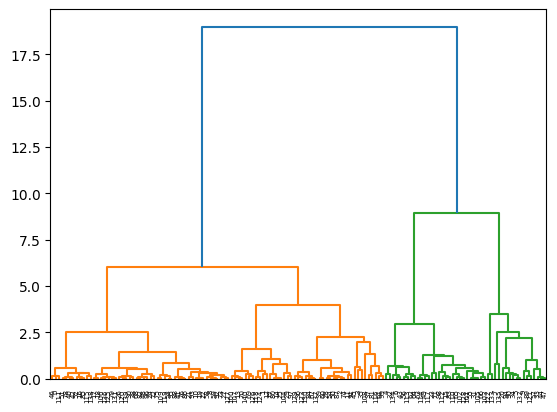

Dendogram for df2
ward :	0.00s


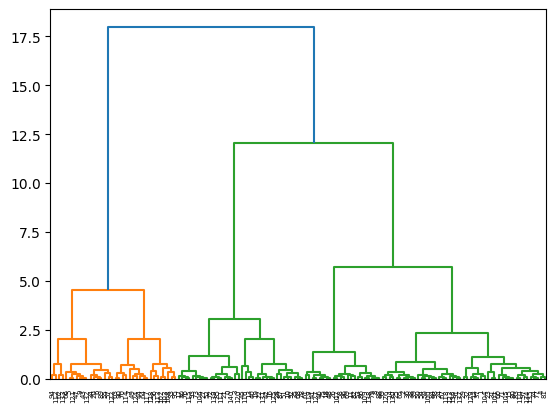

Dendogram for df1
 average :	0.00s


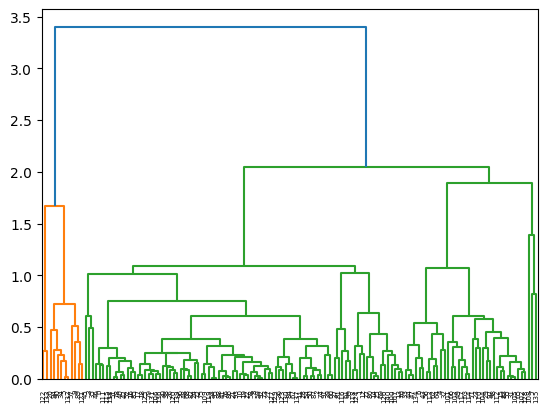

Dendogram for df2
average :	0.00s


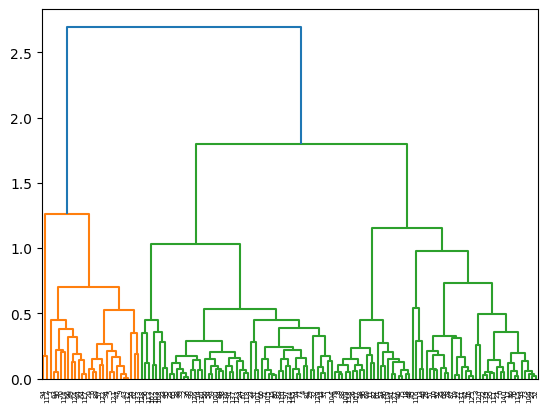

Dendogram for df1
 complete :	0.00s


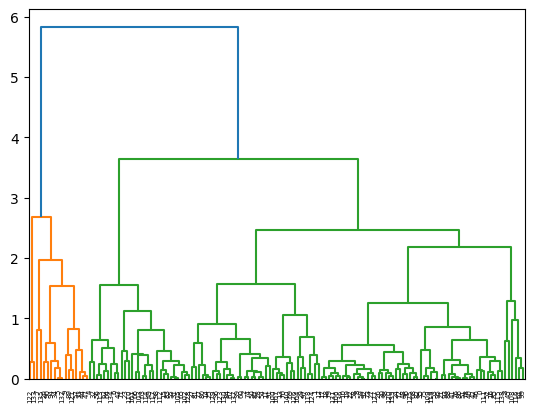

Dendogram for df2
complete :	0.00s


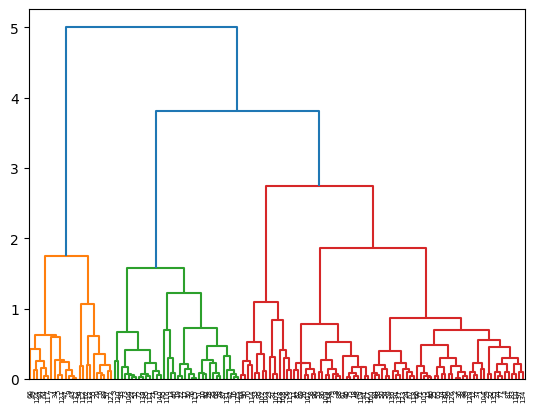

Dendogram for df1
 single :	0.00s


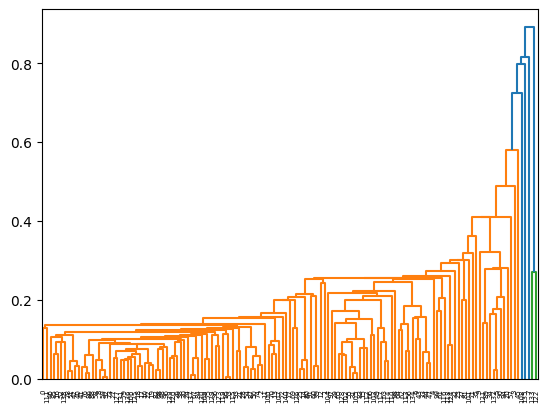

Dendogram for df2
single :	0.00s


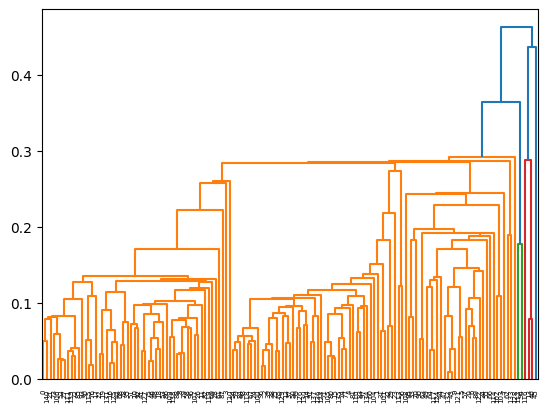

In [ ]:
def plot_endo(df1, df2):
    for linkage in ("ward", "average", "complete", "single"):
        print("Dendogram for df1")

        clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None, distance_threshold=0)
        t0 = time()
        clustering.fit(df1)
        print(" %s :\t%.2fs" % (linkage, time() - t0))

        plt.clf()
        plot_dendogram(clustering)

        print("Dendogram for df2")
        clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None, distance_threshold=0)
        t0 = time()
        clustering.fit(df2)
        print("%s :\t%.2fs" % (linkage, time() - t0))

        plt.clf()
        plot_dendogram(clustering)


plot_endo(df_1_scaled, df_2_scaled)
# plot_endo(df_2_scaled, "2007 with continents")

## Comparativa de dendrogramas (1952 vs 2007)

Probamos distintos métodos de enlace (`ward`, `average`, `complete`, `single`) y comparamos la estructura jerárquica en ambos años.

## Selección de número de clusters

Optamos por `n_clusters = 2` tras inspeccionar los dendrogramas: el salto de distancia sugiere dos grupos principales con buena separación.

In [30]:
modelo_hclust_ward = AgglomerativeClustering(linkage='ward', n_clusters=2)
modelo_hclust_ward.fit(X=df_1_scaled)
cluster_labels = modelo_hclust_ward.fit_predict(X=df_1_scaled)
df_1['cluster'] = cluster_labels

modelo_hclust_ward.fit(X=df_2_scaled)
cluster_labels = modelo_hclust_ward.fit_predict(X=df_2_scaled)
df_2['cluster'] = cluster_labels

## Clustering final y etiquetas

Ajustamos `AgglomerativeClustering` con `ward` y `n_clusters=2` por cada año y guardamos las etiquetas resultantes en cada dataframe.

In [ ]:
df_1s = df_1.sample(50, random_state=42)

paises_sel = df_1s['country']

df_2s = df_2[df_2['country'].isin(paises_sel)]

## Muestreo para visualización

Seleccionamos 50 países aleatorios de 1952 y filtramos 2007 a los mismos países para comparaciones justas en los gráficos.

In [ ]:
print("Paises cluster 0 df_1")
print(df_1[df_1['cluster'] == 0]['country'].sample(5, random_state=1))
print("Paises cluster 1 df_1")
print(df_1[df_1['cluster'] == 1]['country'])

Paises cluster 0 df_1
1332            Serbia
1596    United Kingdom
72             Austria
768              Italy
84             Bahrain
Name: country, dtype: object
Paises cluster 1 df_1
0              Afghanistan
12                 Albania
24                 Algeria
36                  Angola
96              Bangladesh
               ...        
1644               Vietnam
1656    West Bank and Gaza
1668           Yemen, Rep.
1680                Zambia
1692              Zimbabwe
Name: country, Length: 95, dtype: object


## Inspección de países por cluster

Mostramos ejemplos de países en cada cluster para interpretar los grupos (muestras aleatorias para brevedad).

In [ ]:
print("Paises cluster 0 df_2")
print(df_2[df_2['cluster'] == 0]['country'].sample(5, random_state=1))
print("Paises cluster 1 df_2")
print(df_2[df_2['cluster'] == 1]['country'].sample(5, random_state=1))

Paises cluster 0 df_2
1031     Morocco
515     Ethiopia
647        Haiti
1535    Thailand
587        Ghana
Name: country, dtype: object
Paises cluster 1 df_2
1475            Sweden
1607    United Kingdom
1391          Slovenia
119            Belgium
1091       Netherlands
Name: country, dtype: object


### Países por cluster (2007)

Repetimos la inspección para 2007 para comparar con 1952.

In [ ]:
fig = px.scatter(df_1s, x='gdpPercap', y='lifeExp', color='cluster', text=df_1s.country)
fig.show()

## Visualización: 1952

Diagrama de dispersión de `gdpPercap` vs `lifeExp` coloreado por cluster, con etiquetas de país.

In [35]:
fig = px.scatter(df_2s, x='gdpPercap', y='lifeExp', color='cluster', text=df_2s.country)
fig.show()

## Visualización: 2007

Misma visualización para 2007 para comparar el desplazamiento de países entre clusters.

A partir de aquí podríamos añadir visualicación como añadir el continente a la visualización,
dibujar en un mapa mundi cada cluster, o hacer una animación de cómo evoluciona el cluster con el paso
de los años (con un fotograma por cada uno)

Si tuviera más datos que valoraran el grado de desarrollo humano, como % de alfabetización, km de carreteras,
percepción de la corrupción.. etc, podría hacer un PCA, y visualizar en más dimensiones